In [2]:
import os, sys
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LinearRegression
from data_segmentation_high_low_avg_shuffle_plus_mean import segmentate_data
import tensorflow as tf
from typing import Iterable, Tuple
from tensorflow import keras
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from shutil import copyfile
from pickle import load
import seaborn as sns


np.random.seed(42)
tf.random.set_seed(42)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices([physical_devices[0]], 'GPU')

In [3]:
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rcParams["figure.figsize"] = (20,10)

In [4]:
historic_data_in_minibatch = 250
ema_lengths = [3, 5, 8, 9, 10, 13, 20, 21, 26, 34, 50, 55, 89, 100, 144, 200, 233, historic_data_in_minibatch]
len(ema_lengths)

18

# Description
This notebook is used for comparing probability on new data for each day by all prepared models for later comparison.

# Data lodading

In [5]:
data_dir = './data_raw/data_converted_ASK_additional'

In [6]:
files = os.listdir(data_dir)
files = [f for f in files if f.endswith('.csv')]
files.sort()
files

['2021_04_01.csv',
 '2021_04_05.csv',
 '2021_04_06.csv',
 '2021_04_07.csv',
 '2021_04_08.csv',
 '2021_04_09.csv',
 '2021_04_12.csv',
 '2021_04_13.csv',
 '2021_04_14.csv',
 '2021_04_15.csv',
 '2021_04_16.csv',
 '2021_04_19.csv',
 '2021_04_20.csv',
 '2021_04_21.csv',
 '2021_04_22.csv',
 '2021_04_23.csv',
 '2021_04_26.csv',
 '2021_04_27.csv',
 '2021_04_28.csv',
 '2021_04_29.csv',
 '2021_04_30.csv',
 '2021_05_03.csv',
 '2021_05_04.csv',
 '2021_05_05.csv',
 '2021_05_06.csv',
 '2021_05_07.csv',
 '2021_05_10.csv',
 '2021_05_11.csv',
 '2021_05_12.csv',
 '2021_05_13.csv',
 '2021_05_14.csv',
 '2021_05_17.csv',
 '2021_05_18.csv',
 '2021_05_19.csv',
 '2021_05_20.csv',
 '2021_05_21.csv',
 '2021_05_24.csv',
 '2021_05_25.csv']

In [7]:
# _x, _y, _mean = segmentate_data(os.path.join(data_dir, files[0]), historic_data_in_minibatch, 1)
# _x.shape, _y.shape, _mean.shape

In [8]:
def load_data(file_path: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    x, y, mean_data = segmentate_data(file_path, historic_data_in_minibatch, 1, ema_lengths=ema_lengths)
    y = y.reshape((-1,1)) 
    
    df = pd.read_csv(file_path)
    y_actual_values = df['avg_price_in_interval'].to_numpy().reshape((-1,1))
    
    # Copy original y values
    y_org = np.copy(y)
    
    return x, y, mean_data, y_org, y_actual_values

In [9]:
def prepare_data(data: tuple, model_path: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
#     _x, _y, mean_data = segmentate_data(file_path, historic_data_in_minibatch, 1, ema_lengths=ema_lengths)
#     _y = _y.reshape((-1,1)) 
    
#     # Copy original y values
#     y_org = np.copy(_y)

    _x, _y, mean_data, y_org = data

    
    # Data standarization
    _x = _x.reshape((_x.shape[0]), _x.shape[1])
    scaler = load(open(f'./{model_path}/input_scaler_with_ema_shuffled.pkl', 'rb'))
    _x = scaler.transform(_x)
    _x = _x.reshape((_x.shape[0]), _x.shape[1], 1)
    
    # y categorization
    one_ids = np.where(_y >= 0.9)
    zero_ids = np.where(_y < 0.9)
    _y[one_ids[0], one_ids[1]] = 1
    _y[zero_ids[0], zero_ids[1]] = 0
    ones, zeroes = len(one_ids[0]), len(zero_ids[0])
    y = _y.astype(np.int)
    
    # Split for two model inputs
    X_CNN, X_Dense = _x[:, :historic_data_in_minibatch, :], _x[:, historic_data_in_minibatch:, :]
    
    return X_CNN, X_Dense, mean_data, y, y_org

In [10]:
# a,b,c,d,e = prepare_data(os.path.join(data_dir, files[0]), classification_nn_model_path)
# a.shape ,b.shape ,c.shape ,d.shape ,e.shape

# Models loading

## Neural networks

In [11]:
tf.keras.backend.clear_session()

In [12]:
classification_nn_model_path = 'przebieg_2021_05_29-17_08_21'
classification_weights_nn_model_path = 'przebieg_2021_06_05-13_41_25'
classification_optuna_nn_model_path = 'optuna_2021_06_08-18_15_34'

In [13]:
classification_nn_model = tf.keras.models.load_model(
    f'./{classification_nn_model_path}/trained_model')
classification_weights_nn_model = tf.keras.models.load_model(
    f'./{classification_weights_nn_model_path}/trained_model')
classification_optuna_nn_model = tf.keras.models.load_model(
    f'./{classification_optuna_nn_model_path}/trained_model')

In [14]:
models = [
    (classification_nn_model, classification_nn_model_path),
    (classification_weights_nn_model, classification_weights_nn_model_path),
    (classification_optuna_nn_model, classification_optuna_nn_model_path)
]

## Reference models
### x/e model

In [15]:
class XEModel(sklearn.base.BaseEstimator):
    def __init__(self, dropout_qty: int, stock_qty: int, timestamp_pos: int):
        self.dropout_qty = dropout_qty
        self.stock_qty = stock_qty
        self.timestamp_pos = timestamp_pos
        self.sell_at_the_end = False

    def fit(self, X, y):
        return self

    def predict(self, batch: np.ndarray):
        results = []
        for i, X in enumerate(batch):
            stock_prices = X[:self.stock_qty]
            min_in_dropout = np.min(X[:-1])
            if self.sell_at_the_end:
                try:
                    if batch[i + 1, self.timestamp_pos, 0] < X[self.timestamp_pos, 0]:
                        results.append(1)
                        self.sell_at_the_end = False
                    else:
                        results.append(0)
                except IndexError as err:
                    print(err)
                    results.append(1)
                    self.sell_at_the_end = False
            else:
                if X[-1] > min_in_dropout:
                    results.append(1)
                else:
                    self.sell_at_the_end = True
                    results.append(0)
        return np.array(results)

In [16]:
# mean_model = XEModel(250, 250, _timestamp_pos)

### EMA model

In [17]:
class MeanModel(sklearn.base.BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y):
        return self

    def predict(self, batch: np.ndarray):
        # Check X len
        if batch.shape[1] != 4:
            raise Exception(f'Input lenght incorrect, should be equal 4.')
        results = []
        for X in batch:
            prev_avg_price = X[0]
            curr_avg_price = X[1]
            prev_ema = X[2]
            curr_ema = X[3]
            if prev_avg_price > prev_ema and curr_avg_price < curr_ema:
                results.append(1)
            else:
                results.append(0)
        return np.array(results)

# Comparison

In [18]:
def determine_sell_point(model_name: str, date: str, y_pred: np.ndarray, y_org: np.ndarray, y_dolars_values: np.ndarray) -> dict:
    sell_signals = np.where(y_pred == 1.0)
    print((y_pred.shape, y_org.shape, y_dolars_values.shape))
    if len(sell_signals[0]) <= 0:
        print(f'Sell signals qty: {len(sell_signals[0])}\n')
        data = {
            'Date': date,
            'Model': model_name,
            'Sell_price_perc': y_org[-1][0],
            'Sell_price_dolars': y_dolars_values[-1][0],
            'Total_daily_predictions': 0,
            'Mean_in_day_perc': np.mean(y_org),
            'Median_in_day_perc': np.median(y_org),
            'Mean_in_day_dolars': np.mean(y_dolars_values),
            'Median_in_day_dolars': np.median(y_dolars_values)
        }
    else:
        print(f'Sell signals qty: {len(sell_signals[0])}\n')
        first_sell_signal_actual_price = y_org[sell_signals][0]
        first_sell_signal_actual_price_dolars = y_dolars_values[sell_signals][0]
        data = {
            'Date': date,
            'Model': model_name,
            'Sell_price_perc': first_sell_signal_actual_price,
            'Sell_price_dolars': first_sell_signal_actual_price_dolars,
            'Total_daily_predictions': len(sell_signals[0]),
            'Mean_in_day_perc': np.mean(y_org),
            'Median_in_day_perc': np.median(y_org),
            'Mean_in_day_dolars': np.mean(y_dolars_values),
            'Median_in_day_dolars': np.median(y_dolars_values)
        }
    return data

In [19]:
report_df = pd.DataFrame(columns = [
    'Date', 'Model', 'Sell_price_perc', 
    'Sell_price_dolars', 'Total_daily_predictions',
    'Mean_in_day_perc', 'Median_in_day_perc',
    'Mean_in_day_dolars', 'Median_in_day_dolars'
])

In [20]:
treshold = 0.9
for i, file_name in enumerate(files, start=1):
    print(f'{i}/{len(files)}')
    filepath = os.path.join(data_dir, file_name)
    
    x, y, mean_data, y_org, y_dolars_values = load_data(filepath)
    
    for model, model_path in models:
        X_CNN, X_Dense, mean_data, y, y_org = prepare_data((x, y, mean_data, y_org), model_path)
        y_pred = model.predict((X_CNN, X_Dense))
        print(f'\nModel {model_path}\nPredicted min, max range: {np.min(y_pred), np.max(y_pred)}')
        print(f'y_pred shape: {y_pred.shape}')
        
        _pred_one = np.where(y_pred >= treshold)
        _pred_zero = np.where(y_pred < treshold)
        y_pred[_pred_one] = 1.0
        y_pred[_pred_zero] = 0.0
        
        data = determine_sell_point(model_path, file_name[:-4], y_pred, y_org, y_dolars_values)
        report_df = report_df.append(data, ignore_index=True)
    
    # x/e model
    xe_model = XEModel(250, 250, x.shape[1]-1)
    y_pred = xe_model.predict(x)
    y_pred = y_pred.reshape((-1, 1))
    print(f'\nx/e model\nPredicted min, max range: {np.min(y_pred), np.max(y_pred)}')
    print(f'y_pred shape: {y_pred.shape}')
    _pred_one = np.where(y_pred >= treshold)
    _pred_zero = np.where(y_pred < treshold)
    y_pred[_pred_one] = 1.0
    y_pred[_pred_zero] = 0.0
    
    data = determine_sell_point('x/e model', file_name[:-4], y_pred, y_org, y_dolars_values)
    report_df = report_df.append(data, ignore_index=True)
        
    
    # EMA model
    mean_model = MeanModel()
    y_pred = mean_model.predict(mean_data)
    y_pred = y_pred.reshape((-1, 1))
    print(f'\nEMA model\nPredicted min, max range: {np.min(y_pred), np.max(y_pred)}')
    print(f'y_pred shape: {y_pred.shape}')
    
    data = determine_sell_point('EMA model', file_name[:-4], y_pred, y_org, y_dolars_values)
    report_df = report_df.append(data, ignore_index=True)

1/38

Model przebieg_2021_05_29-17_08_21
Predicted min, max range: (3.5352702e-13, 0.00018513958)
y_pred shape: (1933, 1)
((1933, 1), (1933, 1), (2185, 1))
Sell signals qty: 0


Model przebieg_2021_06_05-13_41_25
Predicted min, max range: (3.1144148e-12, 3.857368e-05)
y_pred shape: (1933, 1)
((1933, 1), (1933, 1), (2185, 1))
Sell signals qty: 0


Model optuna_2021_06_08-18_15_34
Predicted min, max range: (7.486643e-19, 1.2520046e-07)
y_pred shape: (1933, 1)
((1933, 1), (1933, 1), (2185, 1))
Sell signals qty: 0

index 1933 is out of bounds for axis 0 with size 1933

x/e model
Predicted min, max range: (0, 1)
y_pred shape: (1933, 1)
((1933, 1), (1933, 1), (2185, 1))
Sell signals qty: 8


EMA model
Predicted min, max range: (0, 1)
y_pred shape: (1933, 1)
((1933, 1), (1933, 1), (2185, 1))
Sell signals qty: 27

2/38

Model przebieg_2021_05_29-17_08_21
Predicted min, max range: (1.175597e-06, 0.7116314)
y_pred shape: (2058, 1)
((2058, 1), (2058, 1), (2310, 1))
Sell signals qty: 0


Model prz


Model przebieg_2021_05_29-17_08_21
Predicted min, max range: (6.108529e-09, 0.06085351)
y_pred shape: (2071, 1)
((2071, 1), (2071, 1), (2323, 1))
Sell signals qty: 0


Model przebieg_2021_06_05-13_41_25
Predicted min, max range: (1.441078e-10, 0.102048896)
y_pred shape: (2071, 1)
((2071, 1), (2071, 1), (2323, 1))
Sell signals qty: 0


Model optuna_2021_06_08-18_15_34
Predicted min, max range: (1.1797545e-22, 0.008989047)
y_pred shape: (2071, 1)
((2071, 1), (2071, 1), (2323, 1))
Sell signals qty: 0


x/e model
Predicted min, max range: (1, 1)
y_pred shape: (2071, 1)
((2071, 1), (2071, 1), (2323, 1))
Sell signals qty: 2071


EMA model
Predicted min, max range: (0, 1)
y_pred shape: (2071, 1)
((2071, 1), (2071, 1), (2323, 1))
Sell signals qty: 26

13/38

Model przebieg_2021_05_29-17_08_21
Predicted min, max range: (6.440144e-11, 0.00017284279)
y_pred shape: (2076, 1)
((2076, 1), (2076, 1), (2328, 1))
Sell signals qty: 0


Model przebieg_2021_06_05-13_41_25
Predicted min, max range: (1.827


Model przebieg_2021_05_29-17_08_21
Predicted min, max range: (2.35415e-12, 4.72487e-05)
y_pred shape: (2085, 1)
((2085, 1), (2085, 1), (2337, 1))
Sell signals qty: 0


Model przebieg_2021_06_05-13_41_25
Predicted min, max range: (1.7887197e-13, 4.060591e-06)
y_pred shape: (2085, 1)
((2085, 1), (2085, 1), (2337, 1))
Sell signals qty: 0


Model optuna_2021_06_08-18_15_34
Predicted min, max range: (3.0284585e-25, 6.5369243e-10)
y_pred shape: (2085, 1)
((2085, 1), (2085, 1), (2337, 1))
Sell signals qty: 0

index 2085 is out of bounds for axis 0 with size 2085

x/e model
Predicted min, max range: (0, 1)
y_pred shape: (2085, 1)
((2085, 1), (2085, 1), (2337, 1))
Sell signals qty: 19


EMA model
Predicted min, max range: (0, 1)
y_pred shape: (2085, 1)
((2085, 1), (2085, 1), (2337, 1))
Sell signals qty: 34

24/38

Model przebieg_2021_05_29-17_08_21
Predicted min, max range: (3.488082e-14, 0.11267894)
y_pred shape: (2069, 1)
((2069, 1), (2069, 1), (2321, 1))
Sell signals qty: 0


Model przebieg


Model przebieg_2021_05_29-17_08_21
Predicted min, max range: (1.9298278e-11, 0.57292247)
y_pred shape: (2084, 1)
((2084, 1), (2084, 1), (2336, 1))
Sell signals qty: 0


Model przebieg_2021_06_05-13_41_25
Predicted min, max range: (3.2150368e-08, 0.9450729)
y_pred shape: (2084, 1)
((2084, 1), (2084, 1), (2336, 1))
Sell signals qty: 8


Model optuna_2021_06_08-18_15_34
Predicted min, max range: (2.7739776e-16, 0.9999999)
y_pred shape: (2084, 1)
((2084, 1), (2084, 1), (2336, 1))
Sell signals qty: 152


x/e model
Predicted min, max range: (1, 1)
y_pred shape: (2084, 1)
((2084, 1), (2084, 1), (2336, 1))
Sell signals qty: 2084


EMA model
Predicted min, max range: (0, 1)
y_pred shape: (2084, 1)
((2084, 1), (2084, 1), (2336, 1))
Sell signals qty: 38

35/38

Model przebieg_2021_05_29-17_08_21
Predicted min, max range: (3.5666622e-07, 0.08945286)
y_pred shape: (2047, 1)
((2047, 1), (2047, 1), (2299, 1))
Sell signals qty: 0


Model przebieg_2021_06_05-13_41_25
Predicted min, max range: (3.31906

In [21]:
report_df['Date'] = pd.to_datetime(report_df['Date'], format='%Y_%m_%d')
report_df

,Date,Model,Sell_price_perc,Sell_price_dolars,Total_daily_predictions,Mean_in_day_perc,Median_in_day_perc,Mean_in_day_dolars,Median_in_day_dolars
0,2021-04-01,przebieg_2021_05_29-17_08_21,0.279141,122.9730,0,0.318761,0.310123,123.092750,123.143
1,2021-04-01,przebieg_2021_06_05-13_41_25,0.279141,122.9730,0,0.318761,0.310123,123.092750,123.143
2,2021-04-01,optuna_2021_06_08-18_15_34,0.279141,122.9730,0,0.318761,0.310123,123.092750,123.143
3,2021-04-01,x/e model,0.463497,123.7125,8,0.318761,0.310123,123.092750,123.143
4,2021-04-01,EMA model,0.576994,123.7720,27,0.318761,0.310123,123.092750,123.143
...,...,...,...,...,...,...,...,...,...
185,2021-05-25,przebieg_2021_05_29-17_08_21,0.299046,126.9435,0,0.258034,0.260247,126.886646,126.864
186,2021-05-25,przebieg_2021_06_05-13_41_25,0.299046,126.9435,0,0.258034,0.260247,126.886646,126.864
187,2021-05-25,optuna_2021_06_08-18_15_34,0.299046,126.9435,0,0.258034,0.260247,126.886646,126.864
188,2021-05-25,x/e model,0.332560,127.7935,3,0.258034,0.260247,126.886646,126.864


In [22]:
report_df[report_df['Model'] == 'optuna_2021_06_08-18_15_34'].count()

Date                       38
Model                      38
Sell_price_perc            38
Sell_price_dolars          38
Total_daily_predictions    38
Mean_in_day_perc           38
Median_in_day_perc         38
Mean_in_day_dolars         38
Median_in_day_dolars       38
dtype: int64

In [30]:
report_df[(report_df['Model'] == 'optuna_2021_06_08-18_15_34') & (report_df['Total_daily_predictions'] == 0)]

,Date,Model,Sell_price_perc,Sell_price_dolars,Total_daily_predictions,Mean_in_day_perc,Median_in_day_perc,Mean_in_day_dolars,Median_in_day_dolars,Buy_price
2,2021-04-01,optuna_2021_06_08-18_15_34,0.279141,122.9730,0,0.318761,0.310123,123.092750,123.1430,110.0
12,2021-04-06,optuna_2021_06_08-18_15_34,0.303174,126.2080,0,0.510031,0.503831,126.421149,126.4125,110.0
32,2021-04-12,optuna_2021_06_08-18_15_34,0.309693,131.3970,0,0.353847,0.328605,131.476689,131.4225,110.0
42,2021-04-14,optuna_2021_06_08-18_15_34,0.063573,132.1080,0,0.396790,0.437301,133.098707,133.1775,110.0
47,2021-04-15,optuna_2021_06_08-18_15_34,0.579832,134.4520,0,0.532311,0.555822,134.396538,134.4225,110.0
52,2021-04-16,optuna_2021_06_08-18_15_34,0.580228,134.0970,0,0.488029,0.478423,133.941990,133.9370,110.0
57,2021-04-19,optuna_2021_06_08-18_15_34,0.674609,134.8825,0,0.526607,0.523455,134.525687,134.4975,110.0
62,2021-04-20,optuna_2021_06_08-18_15_34,0.334757,133.0325,0,0.342892,0.326491,133.320795,133.1525,110.0
72,2021-04-22,optuna_2021_06_08-18_15_34,0.197026,131.9885,0,0.602357,0.637639,133.058122,133.0635,110.0
87,2021-04-27,optuna_2021_06_08-18_15_34,0.308880,134.3485,0,0.362171,0.347490,134.585592,134.5640,110.0


In [24]:
report_df['Buy_price'] = np.full((len(report_df),), 110.0, dtype=np.float64)
report_df

,Date,Model,Sell_price_perc,Sell_price_dolars,Total_daily_predictions,Mean_in_day_perc,Median_in_day_perc,Mean_in_day_dolars,Median_in_day_dolars,Buy_price
0,2021-04-01,przebieg_2021_05_29-17_08_21,0.279141,122.9730,0,0.318761,0.310123,123.092750,123.143,110.0
1,2021-04-01,przebieg_2021_06_05-13_41_25,0.279141,122.9730,0,0.318761,0.310123,123.092750,123.143,110.0
2,2021-04-01,optuna_2021_06_08-18_15_34,0.279141,122.9730,0,0.318761,0.310123,123.092750,123.143,110.0
3,2021-04-01,x/e model,0.463497,123.7125,8,0.318761,0.310123,123.092750,123.143,110.0
4,2021-04-01,EMA model,0.576994,123.7720,27,0.318761,0.310123,123.092750,123.143,110.0
...,...,...,...,...,...,...,...,...,...,...
185,2021-05-25,przebieg_2021_05_29-17_08_21,0.299046,126.9435,0,0.258034,0.260247,126.886646,126.864,110.0
186,2021-05-25,przebieg_2021_06_05-13_41_25,0.299046,126.9435,0,0.258034,0.260247,126.886646,126.864,110.0
187,2021-05-25,optuna_2021_06_08-18_15_34,0.299046,126.9435,0,0.258034,0.260247,126.886646,126.864,110.0
188,2021-05-25,x/e model,0.332560,127.7935,3,0.258034,0.260247,126.886646,126.864,110.0


<AxesSubplot:xlabel='Date'>

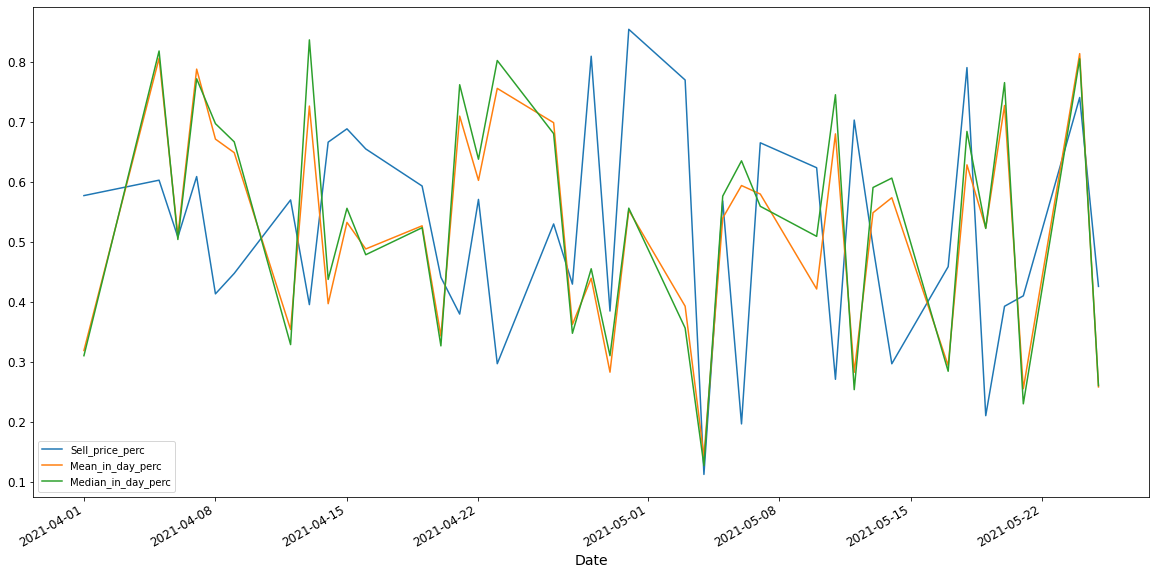

In [25]:
report_df[report_df['Model'] == 'EMA model'].plot(x='Date', y=['Sell_price_perc', 'Mean_in_day_perc', 'Median_in_day_perc'])

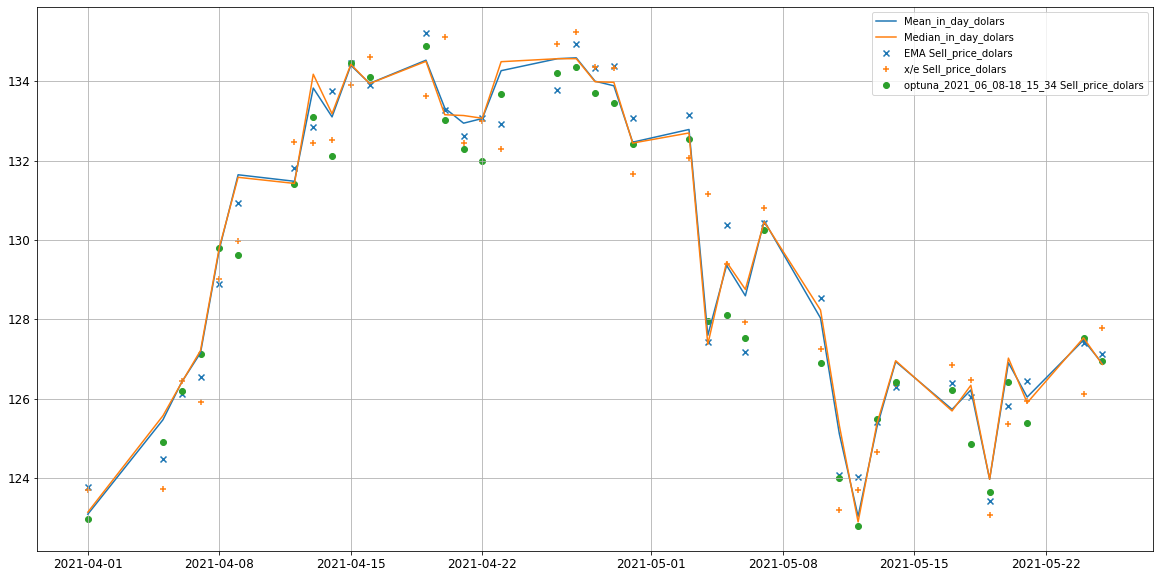

In [26]:
plt.scatter(
    report_df[report_df['Model'] == 'EMA model']['Date'], 
    report_df[report_df['Model'] == 'EMA model']['Sell_price_dolars'],
    label='EMA Sell_price_dolars', marker = 'x')
plt.scatter(
    report_df[report_df['Model'] == 'x/e model']['Date'], 
    report_df[report_df['Model'] == 'x/e model']['Sell_price_dolars'],
    label='x/e Sell_price_dolars', marker = '+')
# plt.scatter(
#     report_df[report_df['Model'] == 'przebieg_2021_05_29-17_08_21']['Date'], 
#     report_df[report_df['Model'] == 'przebieg_2021_05_29-17_08_21']['Sell_price_perc'],
#     label='przebieg_2021_05_29-17_08_21 Sell_price_perc', marker = '+')
# plt.scatter(
#     report_df[report_df['Model'] == 'przebieg_2021_06_05-13_41_25']['Date'], 
#     report_df[report_df['Model'] == 'przebieg_2021_06_05-13_41_25']['Sell_price_perc'],
#     label='przebieg_2021_06_05-13_41_25 Sell_price_perc', marker = '+')
plt.plot(
    report_df[report_df['Model'] == 'optuna_2021_06_08-18_15_34']['Date'], 
    report_df[report_df['Model'] == 'optuna_2021_06_08-18_15_34']['Mean_in_day_dolars'],
    label='Mean_in_day_dolars'
)
plt.plot(
    report_df[report_df['Model'] == 'optuna_2021_06_08-18_15_34']['Date'], 
    report_df[report_df['Model'] == 'optuna_2021_06_08-18_15_34']['Median_in_day_dolars'],
    label='Median_in_day_dolars'
)
plt.scatter(
    report_df[report_df['Model'] == 'optuna_2021_06_08-18_15_34']['Date'], 
    report_df[report_df['Model'] == 'optuna_2021_06_08-18_15_34']['Sell_price_dolars'],
    label='optuna_2021_06_08-18_15_34 Sell_price_dolars', marker = 'o')
plt.legend()
plt.grid()
plt.show()

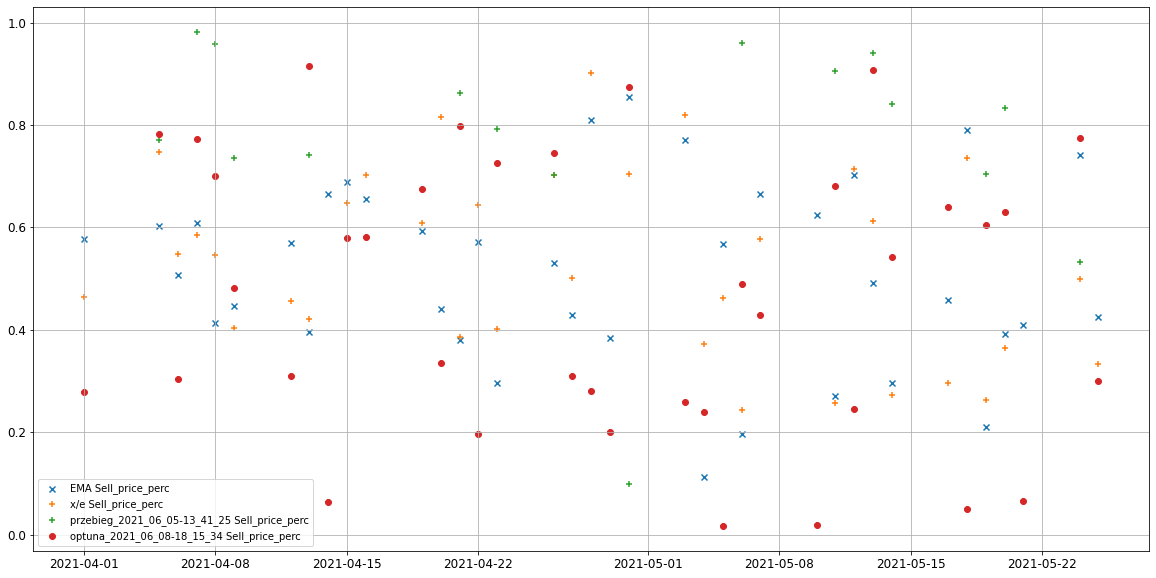

In [27]:
plt.scatter(
    report_df[report_df['Model'] == 'EMA model']['Date'], 
    report_df[report_df['Model'] == 'EMA model']['Sell_price_perc'],
    label='EMA Sell_price_perc', marker = 'x')
plt.scatter(
    report_df[report_df['Model'] == 'x/e model']['Date'], 
    report_df[report_df['Model'] == 'x/e model']['Sell_price_perc'],
    label='x/e Sell_price_perc', marker = '+')
# plt.scatter(
#     report_df[report_df['Model'] == 'przebieg_2021_05_29-17_08_21']['Date'], 
#     report_df[report_df['Model'] == 'przebieg_2021_05_29-17_08_21']['Sell_price_perc'],
#     label='przebieg_2021_05_29-17_08_21 Sell_price_perc', marker = '+')
plt.scatter(
    report_df[report_df['Model'] == 'przebieg_2021_06_05-13_41_25']['Date'], 
    report_df[report_df['Model'] == 'przebieg_2021_06_05-13_41_25']['Sell_price_perc'],
    label='przebieg_2021_06_05-13_41_25 Sell_price_perc', marker = '+')
# plt.plot(
#     report_df[report_df['Model'] == 'optuna_2021_06_08-18_15_34']['Date'], 
#     report_df[report_df['Model'] == 'optuna_2021_06_08-18_15_34']['Mean_in_day_dolars'],
#     label='Mean_in_day_dolars'
# )
# plt.plot(
#     report_df[report_df['Model'] == 'optuna_2021_06_08-18_15_34']['Date'], 
#     report_df[report_df['Model'] == 'optuna_2021_06_08-18_15_34']['Median_in_day_dolars'],
#     label='Median_in_day_dolars'
# )
plt.scatter(
    report_df[report_df['Model'] == 'optuna_2021_06_08-18_15_34']['Date'], 
    report_df[report_df['Model'] == 'optuna_2021_06_08-18_15_34']['Sell_price_perc'],
    label='optuna_2021_06_08-18_15_34 Sell_price_perc', marker = 'o')
plt.legend()
plt.grid()
plt.show()

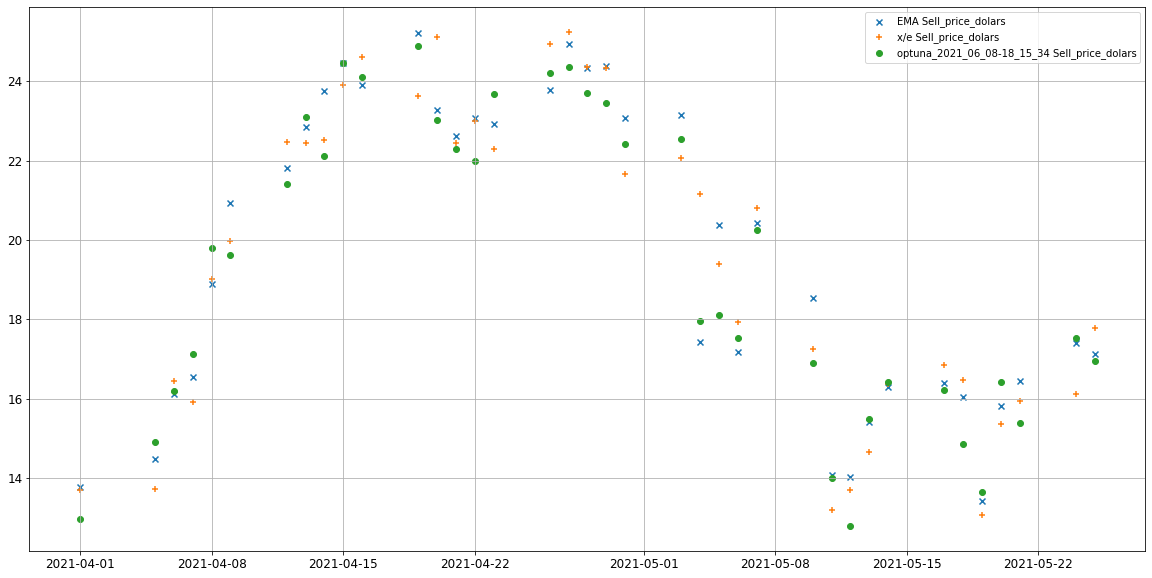

In [28]:
plt.scatter(
    report_df[report_df['Model'] == 'EMA model']['Date'], 
    report_df[report_df['Model'] == 'EMA model']['Sell_price_dolars']-report_df[report_df['Model'] == 'EMA model']['Buy_price'],
    label='EMA Sell_price_dolars', marker = 'x')
plt.scatter(
    report_df[report_df['Model'] == 'x/e model']['Date'], 
    report_df[report_df['Model'] == 'x/e model']['Sell_price_dolars']-report_df[report_df['Model'] == 'x/e model']['Buy_price'],
    label='x/e Sell_price_dolars', marker = '+')
# plt.scatter(
#     report_df[report_df['Model'] == 'przebieg_2021_05_29-17_08_21']['Date'], 
#     report_df[report_df['Model'] == 'przebieg_2021_05_29-17_08_21']['Sell_price_perc'],
#     label='przebieg_2021_05_29-17_08_21 Sell_price_perc', marker = '+')
# plt.scatter(
#     report_df[report_df['Model'] == 'przebieg_2021_06_05-13_41_25']['Date'], 
#     report_df[report_df['Model'] == 'przebieg_2021_06_05-13_41_25']['Sell_price_perc'],
#     label='przebieg_2021_06_05-13_41_25 Sell_price_perc', marker = '+')
# plt.plot(
#     report_df[report_df['Model'] == 'optuna_2021_06_08-18_15_34']['Date'], 
#     report_df[report_df['Model'] == 'optuna_2021_06_08-18_15_34']['Mean_in_day_dolars'],
#     label='Mean_in_day_dolars'
# )
# plt.plot(
#     report_df[report_df['Model'] == 'optuna_2021_06_08-18_15_34']['Date'], 
#     report_df[report_df['Model'] == 'optuna_2021_06_08-18_15_34']['Median_in_day_dolars'],
#     label='Median_in_day_dolars'
# )
plt.scatter(
    report_df[report_df['Model'] == 'optuna_2021_06_08-18_15_34']['Date'], 
    report_df[report_df['Model'] == 'optuna_2021_06_08-18_15_34']['Sell_price_dolars']-report_df[report_df['Model'] == 'optuna_2021_06_08-18_15_34']['Buy_price'],
    label='optuna_2021_06_08-18_15_34 Sell_price_dolars', marker = 'o')
plt.legend()
plt.grid()
plt.show()